In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".25"

import torch
torch.multiprocessing.set_start_method('spawn')

In [3]:
# Add parent folder to path (to run this file from subdirectories)
(parent_folder_path, current_dir) = os.path.split(os.path.abspath(''))
sys.path.append(parent_folder_path)

# add git submodule to path to allow imports to work
submodule_name = 'AlphaTrade'
sys.path.append(os.path.join(parent_folder_path, submodule_name))

from gymnax_exchange.jaxob.jorderbook import OrderBook
import gymnax_exchange.jaxob.JaxOrderbook as job

2023-08-16 12:58:52.430190: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nfs/home/peern/rlenv/lib/python3.8/site-packages/nvidia/cuda_runtime/lib/:/nfs/home/peern/rlenv/lib/python3.8/site-packages/tensorrt/:/nfs/home/peern/rlenv/lib/python3.8/site-packages/nvidia/cuda_runtime/lib/:/usr/local/cuda-11.2/lib64:
2023-08-16 12:58:52.430223: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:264] failed call to cuInit: UNKNOWN ERROR (303)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
from argparse import Namespace
from glob import glob
import numpy as onp
import pandas as pd
from functools import partial
from typing import Union, Optional
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from line_profiler import LineProfiler

import jax
import jax.numpy as jnp
from jax.nn import one_hot
from jax import random
from jax.scipy.linalg import block_diag
from flax import jax_utils
from flax.training import checkpoints
import orbax

#from lob.lob_seq_model import BatchLobPredModel
from lob.train_helpers import create_train_state, eval_step, prep_batch, cross_entropy_loss, compute_accuracy
from s5.ssm import init_S5SSM
from s5.ssm_init import make_DPLR_HiPPO
from s5.dataloading import make_data_loader
from lob_seq_model import LobPredModel
from encoding import Vocab, Message_Tokenizer
from lobster_dataloader import LOBSTER_Dataset, LOBSTER_Subset, LOBSTER_Sampler, LOBSTER

import preproc
import inference
import validation_helpers as valh
from lob.init_train import init_train_state, load_checkpoint, load_args_from_checkpoint
import lob.encoding as encoding

# necessary for flax checkpoints to be loaded in jupyter notebook
import nest_asyncio
nest_asyncio.apply()

## Model

In [5]:
n_messages = 500
v = Vocab()
n_classes = len(v)
seq_len = n_messages * Message_Tokenizer.MSG_LEN
book_dim = 501 #b_enc.shape[1]
book_seq_len = n_messages

rng = jax.random.PRNGKey(42)
rng, rng_ = jax.random.split(rng)

In [6]:
stock = 'GOOG' # 'GOOG', 'NFLX', 'INTC'

In [7]:
# ckpt_path = '../checkpoints/brisk-surf-147_yc8wpyi3/'
# ckpt_path = '../checkpoints/scarlet-voice-168_iqq80fnp/'
# ckpt_path = '../checkpoints/ancient-dawn-506_ykmjf41l/'  # FLAIR Node trained on 0.5 years of GOOG
# ckpt_path = '../checkpoints/bumbling-sun-108_idstu91x/'  # new encoding
# ckpt_path = '../checkpoints/rare-field-129_i52a4aga/'  # new encoding, 0.5 years of GOOG
# ckpt_path = '../checkpoints/autumn-elevator-133_n7oa0i2g/'  # fast encoding
# ckpt_path = '../checkpoints/swept-river-135_3kcdrclh/' # after fixing rounding bugs

if stock == 'GOOG':
    ckpt_path = '../checkpoints/treasured-leaf-149_84yhvzjt/' # 0.5 y GOOG, (full model)
elif stock == 'NFLX':
    ckpt_path = '../checkpoints/fanciful-grass-151_q36k51ii/' # 0.5 y NFLX, (full model)
elif stock == 'INTC':
    ckpt_path = '../checkpoints/pleasant-cherry-152_i6h5n74c/' # 0.5 y INTC, (full model)

In [8]:
ckpt_path

'../checkpoints/treasured-leaf-149_84yhvzjt/'

In [9]:
args = load_args_from_checkpoint(ckpt_path)
args

Namespace(C_init='trunc_standard_normal', USE_WANDB=True, activation_fn='half_glu1', batchnorm=True, bidirectional=True, blocks=8, bn_momentum=0.95, book_depth=500, book_transform=True, bsz=32, clip_eigs=True, conj_sym=True, cosine_anneal=True, d_model=128, dataset='lobster-prediction', dir_name='./data/fast_encoding', discretization='zoh', dt_global=False, dt_max=0.1, dt_min=0.001, early_stop_patience=1000, epochs=100, jax_seed=42, lr_factor=1.0, lr_min=0, lr_patience=1000000, masking='causal', mode='pool', msg_seq_len=500, n_book_post_layers=1, n_book_pre_layers=1, n_data_workers=4, n_layers=6, n_message_layers=2, num_devices=4, opt_config='standard', p_dropout=0.0, prenorm=True, reduce_factor=1.0, restore=None, restore_step=None, ssm_lr_base=0.0005, ssm_size_base=256, use_book_data=True, use_simple_book=False, wandb_entity='peer-nagy', wandb_project='LOBS5', warmup_end=1, weight_decay=0.05)

In [10]:
# scale down to single GPU, single sample inference
args.bsz = 1 #1, 10
args.num_devices = 1

batchnorm = args.batchnorm

In [11]:
# load train state from disk

new_train_state, model_cls = init_train_state(
    args,
    n_classes=n_classes,
    seq_len=seq_len,
    book_dim=book_dim,
    book_seq_len=book_seq_len,
)

ckpt = load_checkpoint(
    new_train_state,
    ckpt_path,
    args.__dict__)
par_state = ckpt['model']

configuring standard optimization setup
[*] Trainable Parameters: 6334776


In [12]:
# deduplicate params (they get saved per gpu in training)
state = par_state.replace(
    params=jax.tree_map(lambda x: x[0], par_state.params),
    batch_stats=jax.tree_map(lambda x: x[0], par_state.batch_stats),
)

In [13]:
model = model_cls(training=False, step_rescale=1.0)

### Forecasting

In [14]:
import lob.evaluation as eval
from lob.preproc import transform_L2_state

In [15]:
n_gen_msgs = 100  #500 # how many messages to generate into the future
n_messages = 500
n_eval_messages = 100  # how many to load from dataset 
eval_seq_len = n_eval_messages * Message_Tokenizer.MSG_LEN

data_levels = 10
sim_book_levels = 20 # 10  # order book simulator levels
sim_queue_len = 100  # per price in sim, how many orders in queue

n_vol_series = 500  # how many book volume series model uses as input

In [16]:
# entire test set after training data

if stock == 'GOOG':
    data_dir = '/nfs/home/peern/LOBS5/data/test_set/GOOG/'
elif stock == 'NFLX':
    data_dir = '/nfs/home/peern/LOBS5/data/test_set/NFLX/'
elif stock == 'INTC':
    data_dir = '/nfs/home/peern/LOBS5/data/test_set/INTC/'

msg_files = sorted(glob(str(data_dir) + '/*message*.npy'))
book_files = sorted(glob(str(data_dir) + '/*book*.npy'))

ds = LOBSTER_Dataset(
    msg_files,
    n_messages=n_messages + n_eval_messages,
    mask_fn=lambda X, rng: (X, jnp.array(0)),
    seed=42,
    n_cache_files=100,
    randomize_offset=False,
    book_files=book_files,
    use_simple_book=True,
    book_transform=False,
    book_depth=500,
    return_raw_msgs=True,
)

In [17]:
data_dir

'/nfs/home/peern/LOBS5/data/test_set/GOOG/'

In [18]:
ds.book_files

['/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-14_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-15_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-16_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-19_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-20_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-21_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-22_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-23_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-27_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-28_34200000_57600000_orderbook_10_p

In [19]:
import chex
chex.clear_trace_counter()

In [20]:
import logging
# logging.basicConfig(filename='ar_debug.log', level=logging.DEBUG)
fhandler = logging.FileHandler(filename='ar_debug.log', mode='w')
logger = logging.getLogger()
if (logger.hasHandlers()):
    logger.handlers.clear()
logger.addHandler(fhandler)
# logger.setLevel(logging.DEBUG)
logger.setLevel(logging.WARNING)

In [185]:
# DEBUG: sim replay

m_seq, _, b_seq_pv, msg_seq_raw, book_l2_init = ds[1]
m_seq_raw_inp = msg_seq_raw[: n_messages]
m_seq_raw_eval = msg_seq_raw[n_messages: ]

sim = OrderBook(price_levels=sim_book_levels, orderQueueLen=sim_queue_len)
# init simulator at the start of the sequence
inference.reset_orderbook(sim, book_l2_init)
# replay sequence in simulator (actual)
# so that sim is at the same state as the model

print('init L2 state')
print(sim.get_L2_state())
print('init book data')
print(b_seq_pv[0, 1:21])

for i in range(m_seq_raw_inp.shape[0] - 1):
    print(i)
    replay = inference.msgs_to_jnp(m_seq_raw_inp[i: i+1])
    print(replay)
    trades = sim.process_orders_array(replay)
    best_bid, best_ask = sim.get_best_bid(), sim.get_best_ask()
    print(
        encoding.repr_raw_msg(m_seq_raw_inp[i])
    )
    print('trades:\n', trades)
    print(best_bid, best_ask)
    print(sim.get_L2_state())
    if best_bid >= best_ask:
        print("ERROR: CROSSED PRICES")
    print('book data')
    print(b_seq_pv[i+1, 1:21])
        
    print()

init L2 state
[979500    185 979100    200 979600    100 979000    300 979700    300
 978900    422 979800    122 978800    300 979900    400 978700    400
 980000  20825 978600    700 980100      9 978500    100 980300    150
 978400    100 980400    100 978100     91 980500      1 978000    416
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
init book data
[979500    185 979100    200 979600    100 979000    300 979700    300
 978900    422 979800    122 978800    300 979900    400 978700    400]
0
[[        1         1       200    978700         0  32658022     34201
  155808573]]
OID:	32658022
event_type:	1
direction:	1
price_abs:	978700
price:	-6
size:	200
delta_t_s:	0
delta_t_ns:	0
time_s:	34201
time_ns:	155808573
p_ref:	-9999
size_ref:	-9999
tim

In [34]:
results = inference.sample_messages(
    n_samples = 1, # 500
    num_repeats = 1,
    ds = ds,
    rng = rng,
    seq_len = seq_len,
    n_msgs = n_messages,
    n_gen_msgs = n_gen_msgs,
    train_state = state,
    model = model,
    batchnorm = batchnorm,
    encoder = v.ENCODING,
    n_vol_series = n_vol_series,
    sim_book_levels = sim_book_levels,
    sim_queue_len = sim_queue_len,
    data_levels = data_levels,
    save_folder='../data/results/{stock}/inference/'
)

  0%|          | 0/1 [00:00<?, ?it/s]

Processing sample 4538...
ITERATION 0


100%|██████████| 1/1 [09:36<00:00, 576.24s/it]


In [22]:
# load all tmp files saved during inference and combine to single dict

import pickle

# tmp_files = glob('./tmp_small/*')
# tmp_files = glob('./tmp/*')

tmp_files = glob(f'../data/results/{stock}/inference/*')

assert len(tmp_files) > 0, 'no tmp files found'

all_metrics = []
for file in tmp_files:
    with open(file, 'rb') as f:
        sequence_metrics = pickle.load(f)
        all_metrics.append(sequence_metrics)
# combine metrics into single dict
results = {
    metric: jnp.array([d[metric] for d in all_metrics])
    for metric in all_metrics[0].keys()
}

### Inference evaluation

In [35]:
results.keys()

dict_keys(['book_losses_l1', 'book_losses_l1_const', 'book_losses_wass', 'book_losses_wass_const', 'delta_t_eval', 'delta_t_gen', 'mid_ret_errs', 'mid_ret_errs_const', 'rets_eval', 'rets_gen', 'l2_book_states', 'l2_book_states_eval', 'num_errors', 'event_types_gen', 'event_types_eval', 'raw_msgs_gen', 'raw_msgs_eval'])

In [38]:
results['rets_gen'].shape

(1, 100)

In [39]:
results['raw_msgs_gen'].shape

(1, 1, 100, 14)

In [41]:
save_folder = f'../data/results/{stock}/losses/'

In [57]:
# calculate sequence losses for test set

valid_mask_array = valh.syntax_validation_matrix()
v = Vocab()
for sample_i in tqdm(range(len(ds))):
    m_seq, _, b_seq_pv, msg_seq_raw, book_l2_init = ds[sample_i]
    # transform book to volume image representation for model
    b_seq = jnp.array(transform_L2_state(b_seq_pv, ds.book_depth, 100))

    losses = inference.calc_sequence_losses(
        m_seq,  # can be as long as you want --> use first 500 to predict, then calc losses autoregr.
        b_seq,
        state,
        model,
        batchnorm,
        500,  # number of messages in the input sequence
        len(v),
        valid_mask_array
    )

    # save losses to disk
    jnp.save(save_folder + f'/seq_losses_{sample_i}.npy', losses, allow_pickle=True)

  0%|          | 0/42434 [00:00<?, ?it/s]

NameError: name 'valid_mask_array' is not defined

In [42]:
# load sequence losses

loss_files = glob(save_folder + '/*.npy')
print('loading loss data from disk...', save_folder)
losses = []
for f in tqdm(loss_files):
    losses.append(jnp.load(f))
losses = jnp.array(losses)

loading loss data from disk... ../data/results/GOOG/losses/


  0%|          | 0/2072 [00:00<?, ?it/s]

In [43]:
losses.shape

(2072, 101, 17)

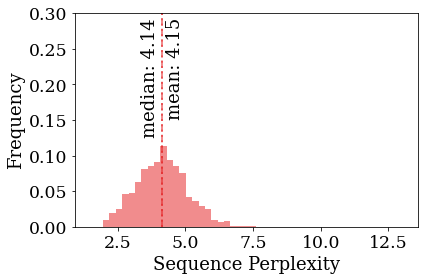

In [25]:
seq_perpl = jnp.exp(losses.mean(axis=(1, 2)))
eval.plot_perplexity_hist(
    seq_perpl,
    min_max=(1.5, 13),
    ylim=(0, 0.3),
    nbins=50
)
plt.savefig(f'../figures/seq_perpl_{stock}.png', dpi=300)

In [44]:
# perplexity per token position --> table
jnp.exp(losses.mean(axis=(0, 1)))

Array([  2.1452491,   1.7127261,   1.0353924,   5.552852 ,   3.1834166,
         1.0019593,   6.214735 , 405.48682  , 770.00806  ,   1.0363657,
         1.4469483,   1.0705057,   1.0073589,   1.625998 ,   2.4061372,
         2.0936184,   1.9338197], dtype=float32)

In [45]:
with onp.printoptions(precision=2, suppress=True):
    print(jnp.exp(losses.mean(axis=(0, 1))))

[  2.15   1.71   1.04   5.55   3.18   1.     6.21 405.49 770.01   1.04
   1.45   1.07   1.01   1.63   2.41   2.09   1.93]


In [46]:
losses.mean()

Array(1.290113, dtype=float32)

In [47]:
losses.shape

(2072, 101, 17)

In [48]:
# calculate perplexity standard error
eval.calc_bootstrapped_ci(losses.reshape(-1), lambda x: jnp.exp(jnp.mean(x)), rng, ci=0.95, n_bootsrap=100)

(Array(0.00429482, dtype=float32), Array([3.626159, 3.641524], dtype=float32))

In [49]:
jnp.exp(losses.mean())

Array(3.633197, dtype=float32)

In [62]:
# calc liquidity provided / taken from raw message data
# pos liquidity provided: type 1 messages
# neg liquidity taken: type 2,3,4 messages
#m_raw = results['raw_msgs_gen'][0, 0]

liq_pro_gen, liq_tak_gen = eval.calc_liquidity(results['raw_msgs_gen'])
liq_pro_eval, liq_tak_eval = eval.calc_liquidity(results['raw_msgs_eval'])

Text(0, 0.5, 'Wasserstein distance')

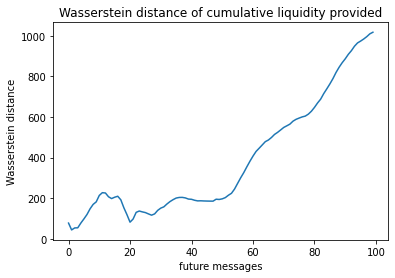

In [63]:
plt.plot(
    eval.wasserstein_vmap(
        jnp.squeeze(liq_pro_eval).T,
        jnp.squeeze(liq_pro_gen).T,
        1
    )
)
plt.title('Wasserstein distance of cumulative liquidity provided')
plt.xlabel('future messages')
plt.ylabel('Wasserstein distance')

Text(0, 0.5, 'Wasserstein distance')

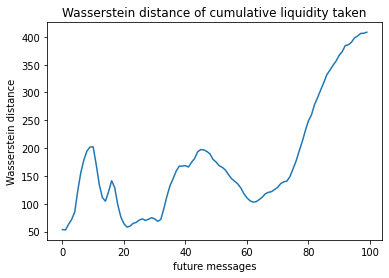

In [64]:
plt.plot(
    eval.wasserstein_vmap(
        jnp.squeeze(liq_tak_eval).T,
        jnp.squeeze(liq_tak_gen).T,
        1
    )
)
plt.title('Wasserstein distance of cumulative liquidity taken')
plt.xlabel('future messages')
plt.ylabel('Wasserstein distance')

In [65]:
b = results['l2_book_states']
b_imb_gen = eval.book_imbalance(b[..., 1], b[..., 3])
b = results['l2_book_states_eval']
b_imb_eval = eval.book_imbalance(b[..., 1], b[..., 3])

Text(0, 0.5, 'Wasserstein distance')

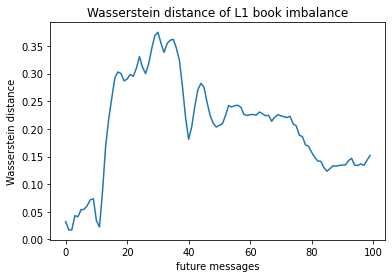

In [66]:
plt.plot(
    eval.wasserstein_vmap(
        jnp.squeeze(b_imb_eval).T,
        jnp.squeeze(b_imb_gen).T,
        1
    )
)

plt.title('Wasserstein distance of L1 book imbalance')
plt.xlabel('future messages')
plt.ylabel('Wasserstein distance')

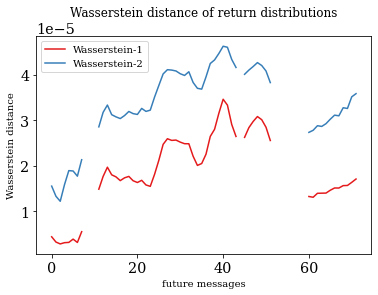

In [131]:
plt.plot(
    eval.wasserstein_vmap(
        results['rets_eval'].T,
        results['rets_gen'].T,
        1
    ),
    label='Wasserstein-1'
)

plt.plot(
    eval.wasserstein_vmap(
        results['rets_eval'].T,
        results['rets_gen'].T,
        2
    ),
    label='Wasserstein-2'
)
plt.title('Wasserstein distance of return distributions')
plt.xlabel('future messages')
plt.ylabel('Wasserstein distance')
plt.legend()

[[0.35251    0.5249197  0.09158999]
 [0.3723705  0.5504002  0.10856   ]]


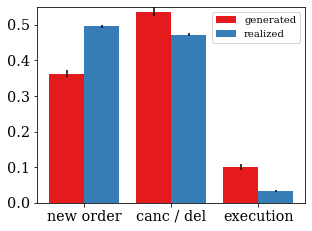

In [29]:
rng, rng_ = jax.random.split(rng)

eval.plot_order_type_frequency(
    results['event_types_gen'],
    results['event_types_eval'],
    rng_,
    combine_mod = True
)
# set y axis limit
plt.ylim(0, 0.55)
plt.savefig(f'../figures/event_types_{stock}.png', dpi=300)

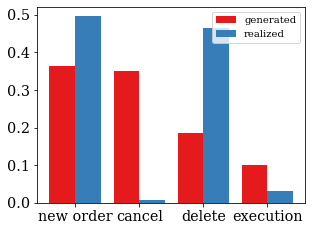

In [106]:
eval.plot_order_type_frequency(
    results['event_types_gen'],
    results['event_types_eval'],
    combine_mod = False
)

In [59]:
min_x = min(results['delta_t_gen'].min(), results['delta_t_eval'].min())
max_x = max(results['delta_t_gen'].max(), results['delta_t_eval'].max())
min_x, max_x
# GOOG: (Array(1.e-09, dtype=float32), Array(875.4253, dtype=float32))
# INTC: 

(Array(1.e-09, dtype=float32), Array(875.4253, dtype=float32))

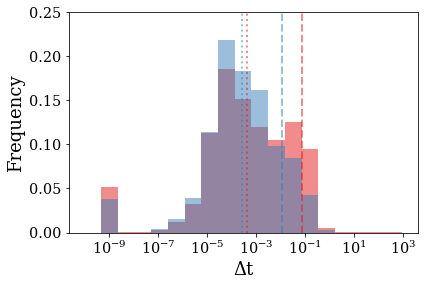

In [61]:
_ = eval.plot_log_hist(results['delta_t_gen'].flatten(), add_text=False, min_max=(1.e-10, 875.4253))
_ = eval.plot_log_hist(results['delta_t_eval'].flatten(), add_text=False, min_max=(1.e-10, 875.4253))
# set y axis limit
plt.ylim(0, 0.25)
plt.savefig(f'../figures/time_hist_{stock}.png', dpi=300)

In [24]:
eval.emp_cdf(results['delta_t_gen'].flatten())

(Array([9.9999997e-10, 9.9999997e-10, 9.9999997e-10, ..., 9.9623138e+02,
        9.9714325e+02, 9.9832538e+02], dtype=float32),
 Array([1.8382352e-05, 3.6764704e-05, 5.5147058e-05, ..., 9.9996322e-01,
        9.9998164e-01, 1.0000000e+00], dtype=float32))

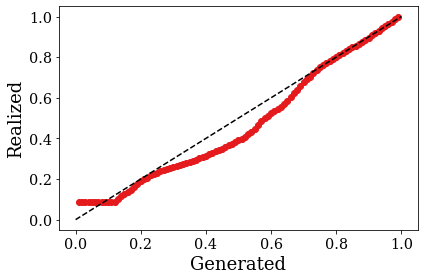

In [284]:
eval.prob_plot_2samples(
    results['delta_t_gen'].flatten(),
    results['delta_t_eval'].flatten()
)
plt.savefig(f'../figures/time_prob_{stock}.png', dpi=300)

In [ ]:
# note: don't make mistake of comparing MEAN generated returns to realised returns

In [291]:
results['num_errors']

Array([[ 33],
       [ 14],
       [ 19],
       [ 16],
       [ 22],
       [ 18],
       [  1],
       [ 34],
       [ 74],
       [ 26],
       [ 25],
       [ 12],
       [  2],
       [ 12],
       [ 29],
       [ 17],
       [ 17],
       [ 37],
       [ 84],
       [ 23],
       [ 16],
       [  4],
       [ 29],
       [ 22],
       [ 11],
       [ 22],
       [ 17],
       [  4],
       [  5],
       [ 30],
       [ 67],
       [ 13],
       [ 12],
       [ 44],
       [ 12],
       [ 23],
       [ 54],
       [  1],
       [ 29],
       [ 28],
       [  6],
       [ 11],
       [ 13],
       [ 25],
       [  2],
       [ 14],
       [108],
       [  4],
       [ 66],
       [ 27],
       [  2],
       [ 17],
       [ 63],
       [  1],
       [ 16],
       [  3],
       [ 37],
       [ 16],
       [ 18],
       [  7],
       [ 15],
       [121],
       [  0],
       [  1],
       [ 13],
       [ 79],
       [ 29],
       [ 49],
       [ 25],
       [ 84],
       [  4],
      

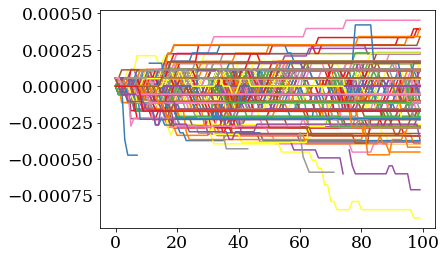

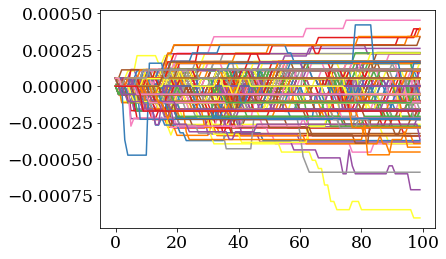

In [51]:
# remove NaNs (temporary empty book side) by forward filling returns

r_gen_df = pd.DataFrame(results['rets_gen'].T)

r_gen_df.plot()
# remove legend from current axis
plt.gca().get_legend().remove()

r_gen_df = r_gen_df.fillna(method='ffill')
r_gen_df.plot()
plt.gca().get_legend().remove()

r_gen = jnp.array(r_gen_df.values).T
r_eval = pd.DataFrame(results['rets_eval'].T).fillna(method='ffill')
r_eval = jnp.array(r_eval.values).T

# remove series starting with NaNs (one empty book side)
r_gen = r_gen[~jnp.isnan(r_eval[:, 0])]  # ... where eval is NaN!
r_eval = r_eval[~jnp.isnan(r_eval[:, 0])]

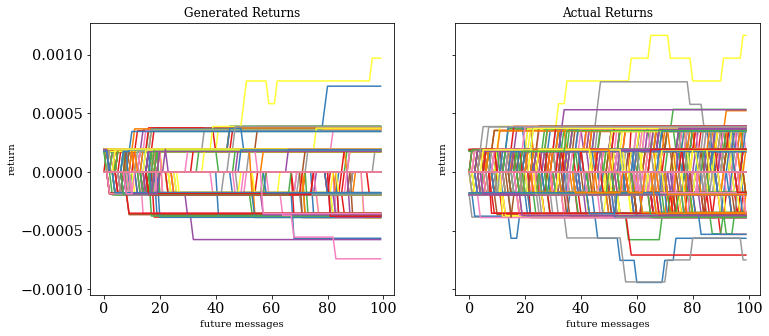

In [286]:
eval.plot_returns(r_gen, r_eval)

In [287]:
results['rets_gen'].shape

(989, 100)

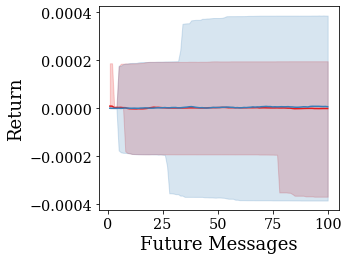

In [288]:
eval.plot_mean_returns(r_gen.T, r_eval.T)
plt.savefig(f'../figures/ret_dist_{stock}.png', dpi=300)

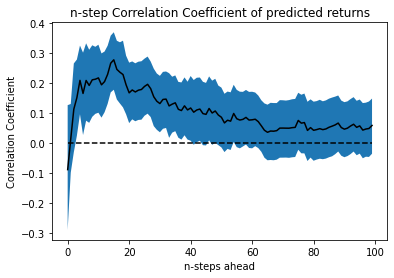

In [44]:
rng, rng_ = jax.random.split(rng)
eval.plot_ret_corr(results['rets_gen'], results['rets_eval'], ci=0.95, rng=rng_)

In [73]:
se, percentiles = eval.calc_moments_se(results['rets_gen'], rng)

In [78]:
percentiles[0].shape

(2, 100)

In [50]:
# forward fill: port this to jax
# mask = jnp.isnan(a)
# idx = jnp.where(~mask, jnp.arange(mask.shape[1]), 0)
# jnp.maximum.accumulate(idx, axis=1, out=idx)
# out = a[jnp.arange(idx.shape[0])[:, None], idx]

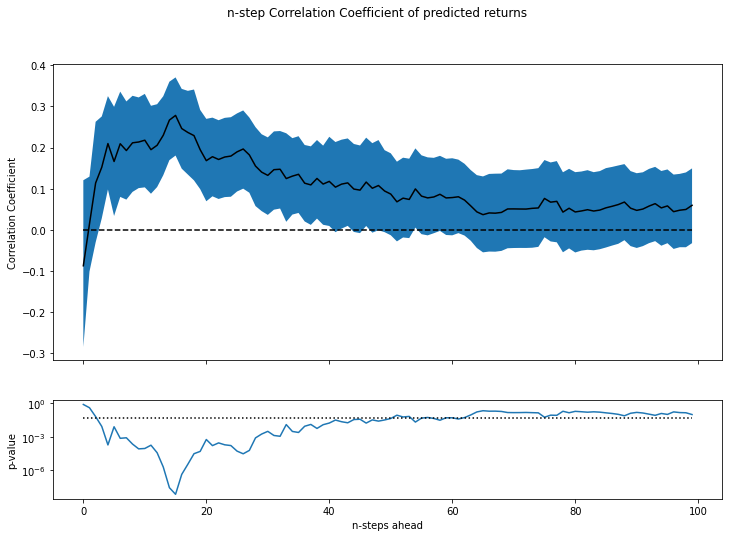

In [69]:
rng, rng_ = jax.random.split(rng)
eval.plot_ret_corr(results['rets_gen'], results['rets_eval'], ci=0.95, rng=rng_)

In [64]:
results['rets_gen'].shape

(576, 100)

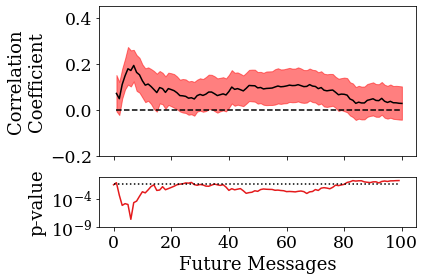

In [52]:
rng, rng_ = jax.random.split(rng)
eval.plot_ret_corr(
    r_gen,
    r_eval,
    ci=0.95,
    ylims=((-0.2, 0.45), (1e-9, 1)),
    rng=rng_
)
plt.savefig(f'../figures/corr_{stock}.png', dpi=300)

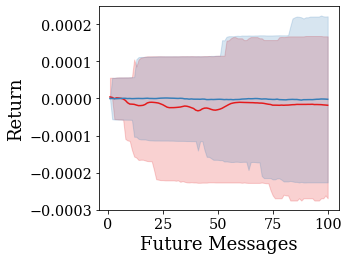

In [240]:
eval.plot_mean_returns(r_gen.T, r_eval.T)

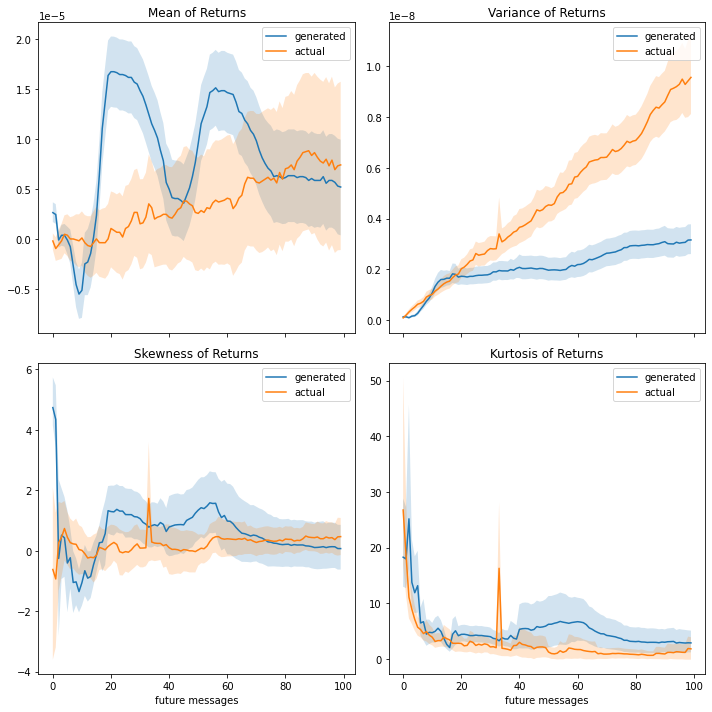

In [87]:
eval.plot_moments(results['rets_gen'], results['rets_eval'], ci=0.95, rng=rng_)

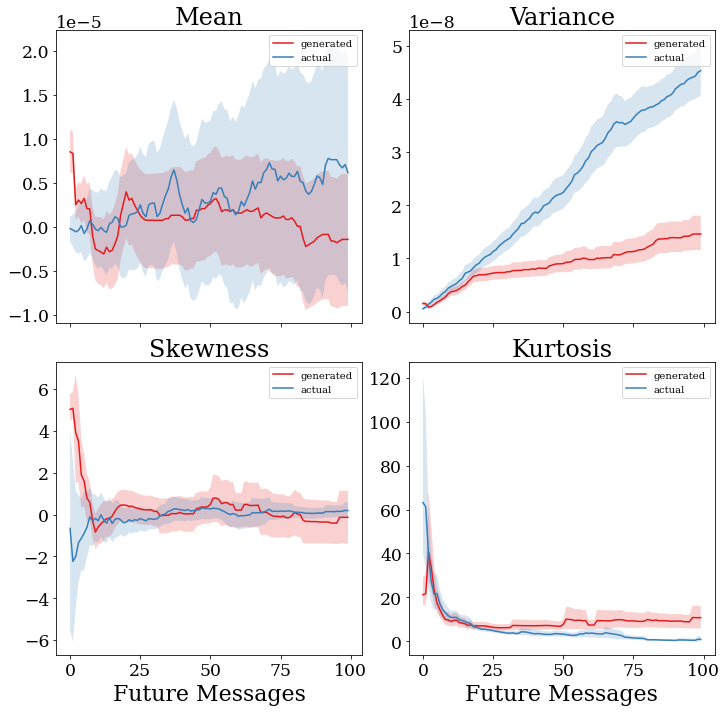

In [290]:
eval.plot_moments(r_gen, r_eval, ci=0.95, rng=rng_)
plt.savefig(f'../figures/moments_{stock}.png', dpi=300)

In [134]:
# TODO: plot this for multiple samples

_ = plt.plot(rets_eval.T, linestyle='--', label='actual')
# reset color cycle
plt.gca().set_prop_cycle(None)
_ = plt.plot(rets_gen.T, label='generated')
plt.legend()

NameError: name 'rets_eval' is not defined

Text(0, 0.5, 'Correlation Coefficient')

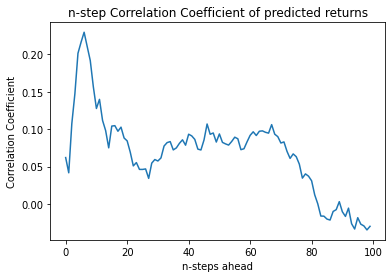

In [55]:
ret_corr = eval.return_corr(r_gen, r_eval)
plt.plot(ret_corr)
plt.title('n-step Correlation Coefficient of predicted returns')
plt.xlabel('n-steps ahead')
plt.ylabel('Correlation Coefficient')

In [ ]:
#mid_price_loss_l1(l2_book_states, l2_book_states_eval)

Array([0. , 0. , 0. , 0. , 1. , 1. , 1.5, 1.5, 2.5, 2.5, 2.5, 3. , 3.5,
       3.5, 3.5, 3.5, 4. , 4. , 4. , 4. , 4. , 4.5, 4.5, 4.5, 5. , 5. ,
       5. , 4.5, 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. ,
       4. , 4. , 4. , 4. , 4. , 4.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5,
       5.5, 5.5, 5.5, 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. ,
       4. , 4. , 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 5. ,
       5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 6. ,
       6. , 6. , 6. , 5.5, 5.5, 5.5, 5.5, 5.5, 5.5],      dtype=float32, weak_type=True)

Text(0, 0.5, 'mean abs. loss')

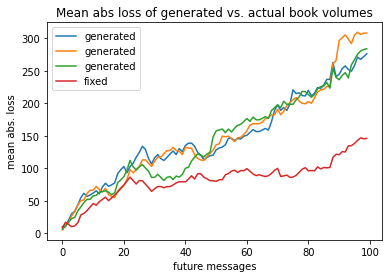

In [24]:
# single data sample

plt.plot(
    onp.arange(book_loss_l1_j.shape[1]),
    book_loss_l1_j.T,
    label='generated'
)
plt.plot(
    book_losses_l1_const.mean(axis=0),
    label='fixed'
)
plt.legend()
plt.title('Mean abs loss of generated vs. actual book volumes')
plt.xlabel('future messages')
plt.ylabel('mean abs. loss')

In [47]:
plt.plot(
    book_losses_wass.mean(axis=(0,1)),
    label='generated'
)
plt.plot(
    book_losses_wass_const.mean(axis=0),
    label='fixed'
)
plt.legend()
plt.title('Evolution of Wasserstein distance of L2 book volumes')
plt.xlabel('future messages')
plt.ylabel('mean abs. loss')

NameError: name 'book_losses_wass' is not defined

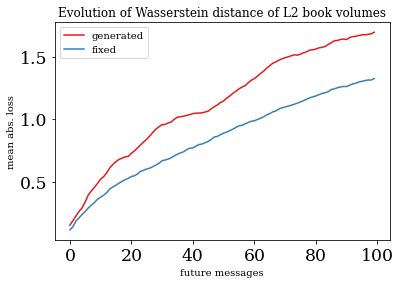

In [256]:
eval.plot_book_losses(
    results['book_losses_wass'],
    results['book_losses_wass_const'],
    'Wasserstein'
)

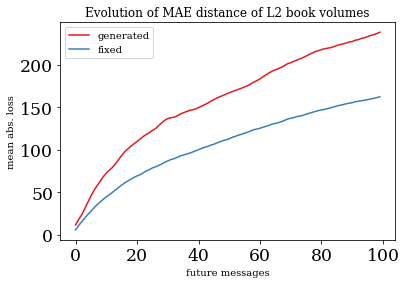

In [257]:
eval.plot_book_losses(
    results['book_losses_l1'],
    results['book_losses_l1_const'],
    'MAE'
)

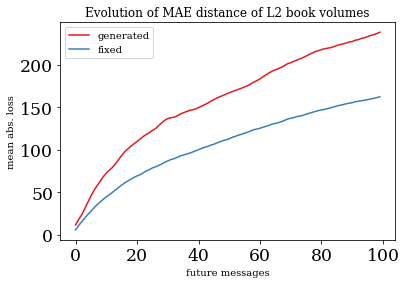

In [258]:
eval.plot_book_losses(
    results['book_losses_l1'],
    results['book_losses_l1_const'],
    'MAE'
)

In [259]:
plt.plot(
    jnp.sqrt(mid_ret_errs.mean(axis=0)),
    label='generated'
)
plt.plot(
    jnp.sqrt(mid_ret_errs_const.mean(axis=0)),
    label='fixed'
)
plt.legend()
plt.title('MSE of mid price returns')
plt.xlabel('Future Messages')
plt.ylabel('Squared Error')

NameError: name 'mid_ret_errs' is not defined

In [64]:
jnp.square(results['rets_gen'] - results['rets_eval']).mean(axis=0)

(535, 100)

Text(0, 0.5, 'Squared Error')

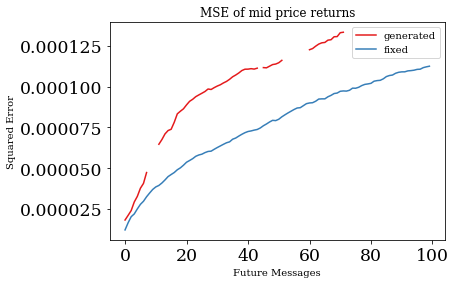

In [260]:
plt.plot(
    jnp.sqrt(jnp.square(results['rets_gen'] - results['rets_eval']).mean(axis=0)),
    label='generated'
)
plt.plot(
    jnp.sqrt(jnp.square(results['rets_eval']).mean(axis=0)),
    label='fixed'
)
plt.legend()
plt.title('MSE of mid price returns')
plt.xlabel('Future Messages')
plt.ylabel('Squared Error')

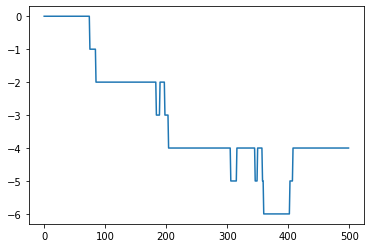

In [65]:
# price drift in sequence
plt.plot(onp.cumsum(b_seq[:, 0]))

In [107]:
def plot_l2_book(i_book, ax, xlim=None, ylim=None):
    i, book = i_book
    book = onp.array(book.reshape((-1, 2)))
    book[::2, 1] = book[::2, 1] * -1
    book = book[book[:, 0] != -1]

    ax.clear()
    plt.title("L2 Book: " + ticker + " - " + data_date + " - " + start_time_dt.strftime("%H:%M:%S"))
    plt.xlabel("Volume")
    plt.ylabel("Price")
    # option 2, remove all lines and collections
    # for artist in ax.lines + ax.collections:
    #     artist.remove()
    time_text = ax.text(
        0.05, 0.95, '#state: ' + str(i),
        horizontalalignment='left',verticalalignment='top',
        transform=ax.transAxes
    )
    
    bars = ax.barh(book[:, 0], book[:, 1], height=90, color='b')
    
    #xlim = ax.get_xlim()
    #x_abs_max = onp.max(onp.abs(xlim))
    #ax.set_xlim(-x_abs_max, x_abs_max)

    ylim = ax.get_ylim()
    p_mid = (book[0, 0] + book[1, 0]) / 2
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is None:
        y_half_range = onp.max((ylim[1] - p_mid, p_mid - ylim[0]))
        ax.set_ylim(p_mid + y_half_range, p_mid - y_half_range)
    else:
        ax.set_ylim(ylim)

    return bars

<BarContainer object of 19 artists>

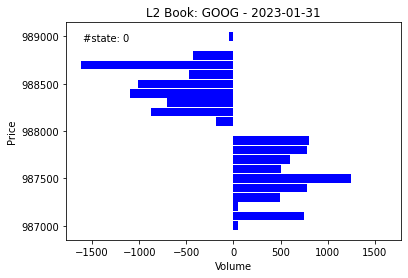

In [91]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.title("L2 Book: " + ticker + " - " + data_date)
plt.xlabel("Volume")
plt.ylabel("Price")
max_vol = int(1.1 * onp.max(l2_book_states.reshape(l2_book_states.shape[0], -1, 2)[:, :, 1]))
xlim = (-max_vol, max_vol)

plot_l2_book((0, l2_book_states[1]), ax, xlim=xlim)

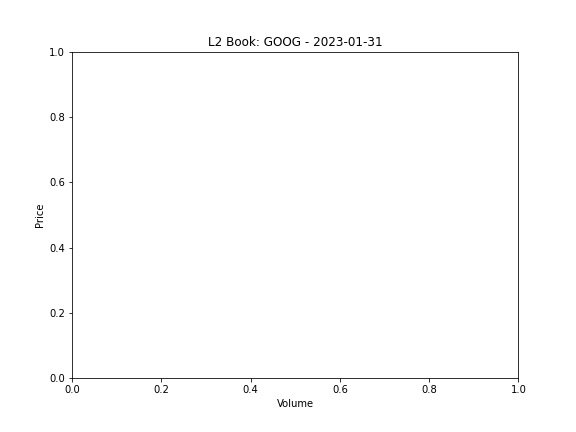

In [115]:
%matplotlib ipympl

import matplotlib.animation

max_vol = int(1.1 * onp.max(l2_book_states.reshape(l2_book_states.shape[0], -1, 2)[:, :, 1]))
xlim = (-max_vol, max_vol)

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)
plt.title("L2 Book: " + ticker + " - " + data_date)
plt.xlabel("Volume")
plt.ylabel("Price")

ani = matplotlib.animation.FuncAnimation(
    fig,
    lambda b: plot_l2_book(b, ax, xlim=xlim),
    frames=list(enumerate(l2_book_states)),
    interval=200,
    repeat_delay=1000,
    #blit=True,
)
#plt.tight_layout()
plt.show()
ani.save(
    '../tmp/animation.webp',
    writer='imagemagick',
    fps=5,
    savefig_kwargs=dict(facecolor='#EAEAF2')
)

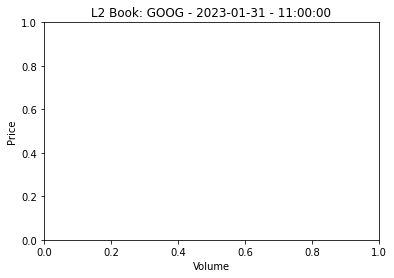

In [130]:
#pause
ani.event_source.stop()

#unpause
#ani.event_source.start()

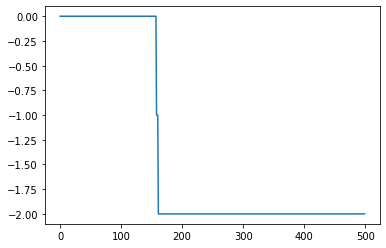

In [150]:
%matplotlib inline

# price drift in sequence
plt.plot(onp.cumsum(b_seq[:, 0]))

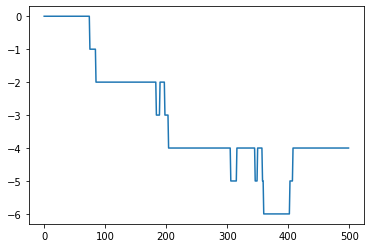

In [120]:
%matplotlib inline

# inspect movement of best bid price for sequence including
# generated flow at the end

# price drift in sequence
plt.plot(onp.cumsum(b_seq[:, 0]))

In [156]:
%matplotlib inline

l = Message_Tokenizer.MSG_LEN
decod_gen_msgs = tok.decode(m_seq.reshape((-1,l))[-100:], v)
decod_gen_msgs = pd.DataFrame(decod_gen_msgs, columns=Message_Tokenizer.FIELDS)
decod_gen_msgs

,time,event_type,size,price,direction,time_new,event_type_new,size_new,price_new,direction_new
0,5.399342e+12,1.0,100.0,-1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,5.399282e+12,1.0,100.0,-2.0,1.0,5.399342e+12,3.0,100.0,-1.0,1.0
2,5.399350e+12,1.0,100.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
3,5.399282e+12,1.0,100.0,-2.0,1.0,5.399350e+12,3.0,100.0,-1.0,1.0
4,5.399257e+12,1.0,200.0,-1.0,1.0,5.399350e+12,2.0,100.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
95,5.399304e+12,1.0,600.0,4.0,0.0,5.399347e+12,2.0,51.0,6.0,0.0
96,5.399299e+12,1.0,100.0,-1.0,1.0,NaN,NaN,NaN,NaN,NaN
97,5.399334e+12,1.0,50.0,-7.0,1.0,5.399298e+12,3.0,50.0,-7.0,1.0
98,5.398295e+12,1.0,306.0,-8.0,1.0,NaN,NaN,NaN,NaN,NaN


In [160]:
%matplotlib inline
decod_gen_msgs['size'].value_counts().sort_index()

3.0       1
21.0      1
25.0      1
50.0     13
51.0     10
61.0      3
100.0    53
200.0    11
300.0     2
306.0     3
600.0     2
Name: size, dtype: int64

<AxesSubplot:>

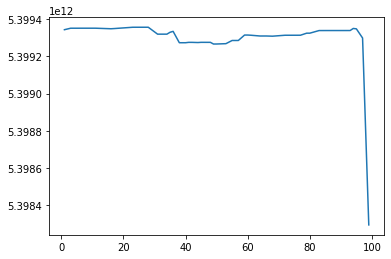

In [161]:
%matplotlib inline

# arriving mod times should be monotonically increasing...
decod_gen_msgs.dropna(subset=['time_new']).time_new.plot()

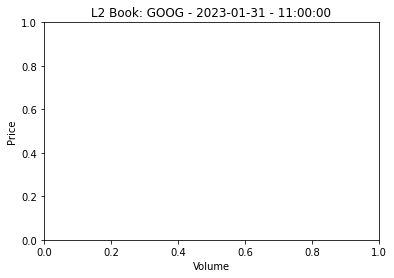

In [162]:
# new orders
new_orders = decod_gen_msgs.loc[decod_gen_msgs.time_new.isna()]

0     5.399342e+12
2     5.399350e+12
12    5.399350e+12
13    5.399346e+12
14    5.399346e+12
15    5.399348e+12
18    5.399372e+12
19    5.399354e+12
20    5.399355e+12
21    5.399355e+12
22    5.399355e+12
29    5.399313e+12
30    5.399317e+12
33    5.399318e+12
37    5.399256e+12
43    5.399273e+12
46    5.399271e+12
51    5.399265e+12
52    5.399265e+12
54    5.399256e+12
58    5.401286e+12
62    5.399311e+12
63    5.399308e+12
65    5.399309e+12
67    5.399309e+12
69    5.399308e+12
70    5.399312e+12
71    5.399312e+12
78    5.399324e+12
81    5.399338e+12
82    5.399338e+12
86    5.399338e+12
92    5.399338e+12
96    5.399299e+12
98    5.398295e+12
Name: time, dtype: float64

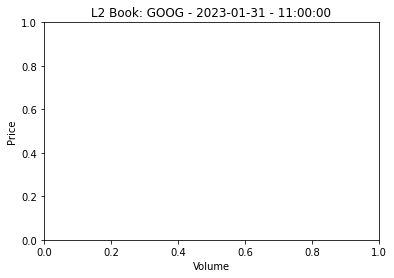

In [163]:
new_orders.time

<AxesSubplot:title={'center':'L2 Book: GOOG - 2023-01-31 - 11:00:00'}, xlabel='Volume', ylabel='Price'>

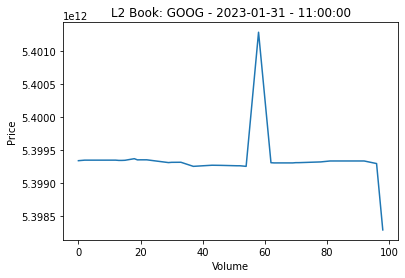

In [164]:
# error: should be monotonically increasing
new_orders.time.plot()

In [74]:
new_orders.event_type.value_counts()

1.0    65
Name: event_type, dtype: int64

In [75]:
# only order modifications
modif_orders = decod_gen_msgs.dropna()

In [76]:
modif_orders.event_type_new.value_counts()

3.0    22
2.0     9
4.0     2
Name: event_type_new, dtype: int64

### Model Validation (optional)

In [ ]:
dataset_obj = LOBSTER(
    'lobster',
    #data_dir='/nfs/home/peern/LOBS5/data/',
    data_dir='/nfs/home/peern/LOBS5/data/new_enc/',
    mask_fn=LOBSTER_Dataset.causal_mask,
    use_book_data=True,
    book_transform=True,
    msg_seq_len=500,
    n_cache_files=100,
)
dataset_obj.setup()

In [ ]:
test_loader = make_data_loader(
    dataset_obj.dataset_test,
    dataset_obj,
    seed=args.jax_seed,
    batch_size=args.bsz,
    drop_last=True,
    shuffle=False,
    num_workers=0
)

In [26]:
rng = jax.random.PRNGKey(42)
tok = Message_Tokenizer()

all_pred_toks = []
all_labels = []

losses = []
accuracy = []
ranks = []
valid_mass = []
valid_mass_n5 = []
valid_pred = []
losses_baseline = []

VALID_MATRIX = valh.syntax_validation_matrix()

for batch_idx, batch in enumerate(tqdm(test_loader)):
    
    # PREPARE BATCH
    inputs, labels, integration_timesteps = prep_batch(batch, seq_len, n_classes, num_devices=1)
    # INFERENCE STEP
    loss, acc, pred = eval_step(
        inputs, labels, integration_timesteps, par_state, model.apply, args.batchnorm)

    loss = loss.squeeze(axis=0)
    acc = acc.squeeze(axis=0)
    pred = pred.squeeze(axis=0)
    
    # STORE RESULTS
    pred_toks = pred.argmax(axis=-1)
    all_labels += labels.tolist()
    all_pred_toks += pred_toks.tolist()
    
    # STATS
    losses.append(cross_entropy_loss(pred, labels))
    accuracy.append(compute_accuracy(pred, labels))
    
    # where does the correct label rank in the predicted distribution?
    ranks.append(valh.pred_rank(pred, labels))
    # how much of the predicted distribution is valid?
    masked_fields = valh.get_masked_fields(batch[0])
    valid_mass.append(valh.valid_prediction_mass(pred, masked_fields))
    valid_mass_n5.append(valh.valid_prediction_mass(pred, masked_fields, top_n=5))

    # check if argmax prediction is valid token for masked fields
    valid_pred.append(valh.is_tok_valid(pred_toks, masked_fields, v))

    # benchmark: uniform prediction over syntactically valid tokens
    pos = valh.get_masked_idx(batch[0])[..., -1]
    baseline_distr = VALID_MATRIX[pos] / VALID_MATRIX[pos].sum(axis=-1, keepdims=True)
    losses_baseline.append(cross_entropy_loss(jnp.log(
            jnp.where(baseline_distr==0, 1e-10, baseline_distr)
        ), labels)
    )

all_labels = jnp.array(all_labels)
all_pred_toks = jnp.array(all_pred_toks)
losses = jnp.array(losses)
accuracy = jnp.array(accuracy)
ranks = jnp.array(ranks)
valid_mass = jnp.array(valid_mass)
valid_mass_n5 = jnp.array(valid_mass_n5)
valid_pred = jnp.array(valid_pred)
losses_baseline = jnp.array(losses_baseline)

NameError: name 'test_loader' is not defined

In [ ]:
print('mean loss', losses.mean())
print('mean accuracy', accuracy.mean())
print('mean rank', ranks.mean())
print('median rank', onp.median(ranks))
print('mean valid mass', valid_mass.mean())
print('mean valid mass (top 5)', valid_mass_n5.mean())
print('mean valid prediction', valid_pred.mean())
print('mean baseline loss (uniform over valid syntax)', losses_baseline.mean())

mean loss 1.4749558
mean accuracy 0.688901
mean rank 72.28813
median rank 0.0
mean valid mass 0.971541
mean valid mass (top 5) 0.9579046
mean valid prediction 0.98988515
mean baseline loss (uniform over valid syntax) 5.2721515


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as onp
import pandas as pd


precision, recall, fscore, support = precision_recall_fscore_support(
    all_labels.astype(int),
    all_pred_toks,
    labels=range(len(v)),
    zero_division=0,
    average=None
)

'''
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
'''

"\nprint('precision: {}'.format(precision))\nprint('recall: {}'.format(recall))\nprint('fscore: {}'.format(fscore))\nprint('support: {}'.format(support))\n"

In [ ]:
field_dec = onp.array([(field, dec) for tok, (field, dec) in sorted(v.DECODING_GLOBAL.items())])

scores_df = pd.DataFrame({
    'field': field_dec[:, 0],
    'decoded': field_dec[:, 1],
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support,
})
#scores_df

In [ ]:
# left to right causal prediction:

scores_df.loc[scores_df.support > 0].groupby('field').agg(
    precision=('precision', 'mean'),
    recall=('recall', 'mean'),
    fscore=('fscore', 'mean'),
    support=('support', 'sum'),
)

,precision,recall,fscore,support
field,,,,
direction,0.624236,0.632841,0.626838,436
event_type,0.393960,0.399946,0.396617,465
generic,1.000000,0.998603,0.999301,716
price,0.557158,0.452684,0.477146,676
size,0.213366,0.152106,0.170773,680
time,0.011118,0.037804,0.016177,685
